# A-Proof: Time series handover analysis

Final analysis performed at handover of the project.

_Ad 1.1: What is the mean or median level of functioning on the different ICF domains at hospital admission, at hospital discharge and at the 6 weeks and 3 months outpatient visits? What is the mean course in the level of functioning of these domains during hospital stay (from admission to discharge)? What is the frequency per ICF domain/level? How many patients improve from discharge to follow-up, how many remain the same? How many deteriorate?_

**Caveats:**
- Only 38 patients had useable annotations.
- The key periods (admission, discharge, checkup 1, checkup 2) were not annotated in this dataset, so they had to be inferred from the number of notes per day.
- 10 patients could not be “aligned” using the above method, so only 28 patients were considered in the final analysis.
- The 28 patients had a number of missing domain scores, resulting in incomplete statistics. Error bars are used (where possible) to illustrate uncertainty, but sample sizes vary over time depending on data availability.

In [1]:
import os
import pickle
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

from class_definitions import Annotation, BertContainer

# Make graphics nice
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set sensible defaults
sns.set()
sns.set_style("ticks")
sns.set_context('paper')

In [2]:
DOMAINCOLS = ['STM_level', 'INS_level', 'BER_level', 'FAC_level']

In [3]:
dfs = []
for aid, annotator in enumerate(['annotator_1', 'annotator_2']):
    for path in Path(f'../timeseries_annotation/{annotator}/completed').glob('*.xlsx'):
        _df = pd.read_excel(path)
        _df['annotator'] = aid
        dfs.append(_df)

df = pd.concat(dfs)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2401 entries, 0 to 42
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   centre      2401 non-null   object 
 1   patient_id  2401 non-null   int64  
 2   note_id     2401 non-null   int64  
 3   note_csn    2401 non-null   int64  
 4   date        2401 non-null   object 
 5   type        2229 non-null   object 
 6   discard     52 non-null     float64
 7   STM_level   263 non-null    float64
 8   INS_level   329 non-null    object 
 9   BER_level   27 non-null     float64
 10  FAC_level   355 non-null    float64
 11  note        2401 non-null   object 
 12  annotator   2401 non-null   int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 262.6+ KB


In [4]:
# Fill dodgy INS values and convert to numeric column
df.loc[(df.INS_level == 'd') | (df.INS_level == '.'), 'INS_level'] = np.nan
df['INS_level'] = pd.to_numeric(df['INS_level'])

# Convert patient and note ids to objects so they don't get computed on
df['patient_id'] = df.patient_id.apply(lambda x: str(x))
df['note_id'] = df.note_id.apply(lambda x: str(x))
df['note_csn'] = df.note_csn.apply(lambda x: str(x))

# Convert date to a datetime object
df['date'] = pd.to_datetime(df.date)

In [5]:
df.patient_id.nunique(), df.patient_id.unique()

(40,
 array(['1848618', '2977287', '7052538', '9172964', '772676', '6403079',
        '8555667', '3174190', '1825193', '1516667', '1827868', '8012257',
        '1826470', '1701305', '1733802', '1830568', '1828353', '6779382',
        '1829083', '1833136', '1683660', '2727819', '7002288', '9058241',
        '1826708', '1830231', '8581219', '1830250', '1245032', '7256295',
        '8297685', '1825973', '3949143', '1228841', '1776065', '1836190',
        '6308072', '1828584', '7283210', '3007670'], dtype=object))

In [6]:
df[~df.discard.isna()].describe()

,discard,STM_level,INS_level,BER_level,FAC_level,annotator
count,52.0,0.0,0.0,0.0,0.0,52.000000
mean,1.0,NaN,NaN,NaN,NaN,0.942308
std,0.0,NaN,NaN,NaN,NaN,0.235435
min,1.0,NaN,NaN,NaN,NaN,0.000000
25%,1.0,NaN,NaN,NaN,NaN,1.000000
50%,1.0,NaN,NaN,NaN,NaN,1.000000
75%,1.0,NaN,NaN,NaN,NaN,1.000000
max,1.0,NaN,NaN,NaN,NaN,1.000000


Note: 49 notes were discarded, all of them seem to be flagged by annotator 1.

In [7]:
df[df.annotator == 1].discard.dropna().count()

49

In [8]:
df[df.annotator == 2].discard.dropna().count()

0

In [9]:
# Drop any patients that don't have a single annotated note
annotated_patients = df.dropna(subset=DOMAINCOLS, how='all').patient_id.unique()
df = df[df.patient_id.isin(annotated_patients)]
df.patient_id.nunique()

38

<AxesSubplot:>

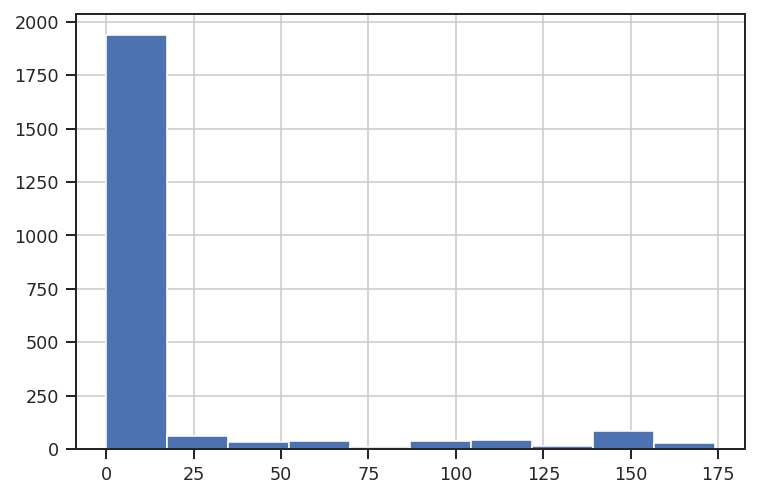

In [10]:
# Add a column to the dataframe tracking elapsed days for the patient*
# *since first annotated note

df['elapsed_days'] = np.nan

for pid in df.patient_id.unique():
    base = df[df.patient_id == pid].sort_values('date', ascending=True)['date'].head(1).values[0]
    df.loc[df.patient_id == pid, 'elapsed_days'] = (df[df.patient_id == pid]['date'] - base).dt.days

df.elapsed_days.hist()

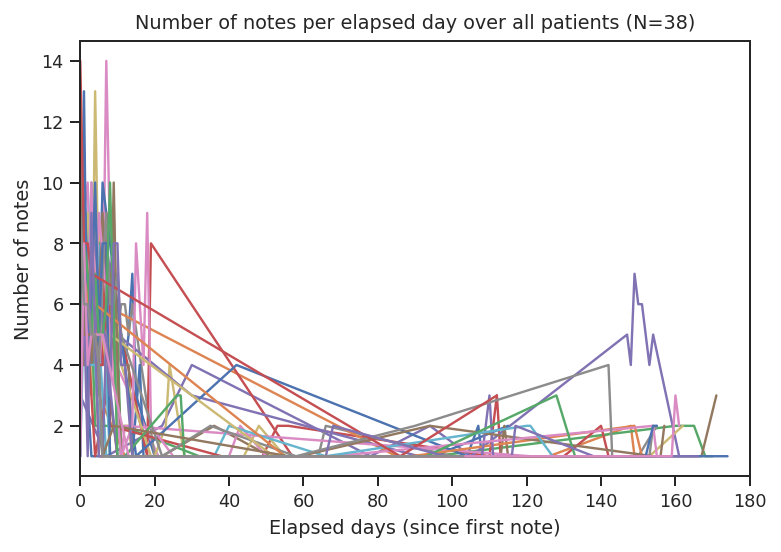

In [11]:
# Detecting different periods in patient history

for pid in df.patient_id.unique():
    _df = df[df.patient_id == pid]
    _df = _df.groupby('elapsed_days').count()
    _df['note_id'].plot()

plt.ylabel('Number of notes')
plt.xlabel('Elapsed days (since first note)')
plt.title(f'Number of notes per elapsed day over all patients (N={df.patient_id.nunique()})')
plt.xlim(0,180)
plt.show()

1848618


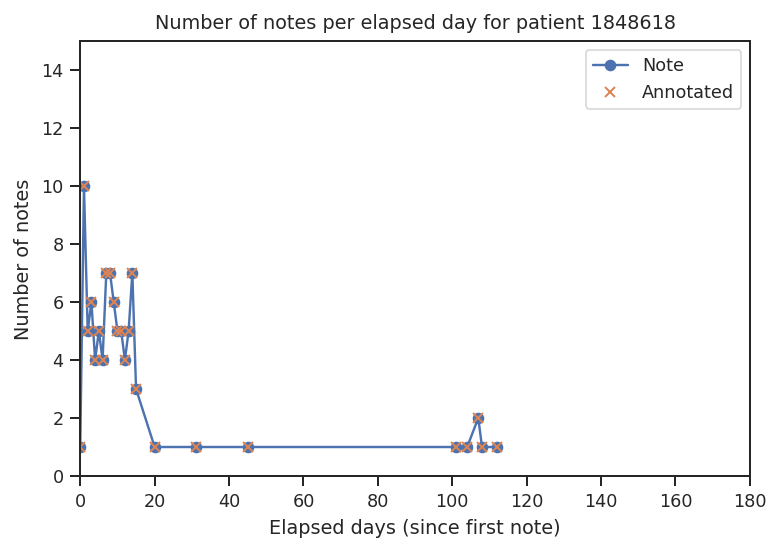

2977287


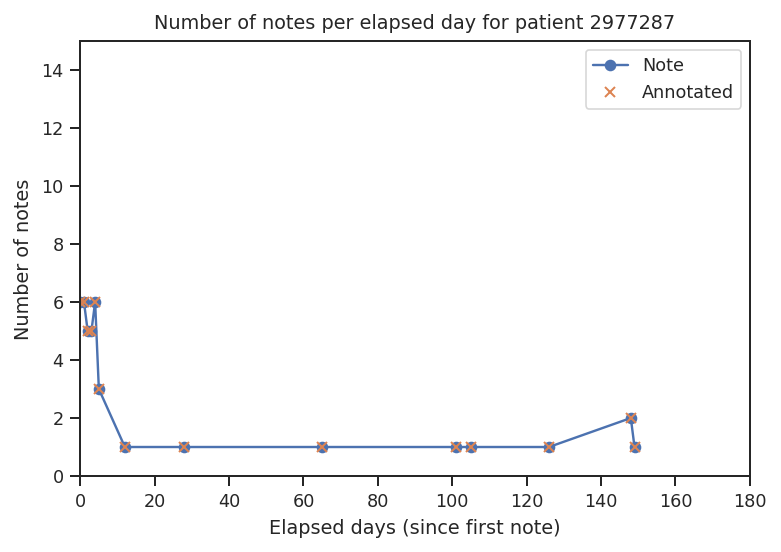

7052538


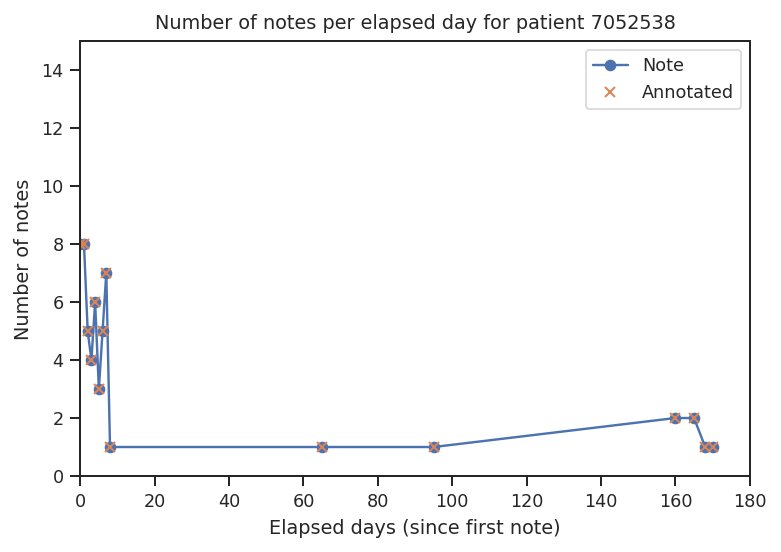

9172964


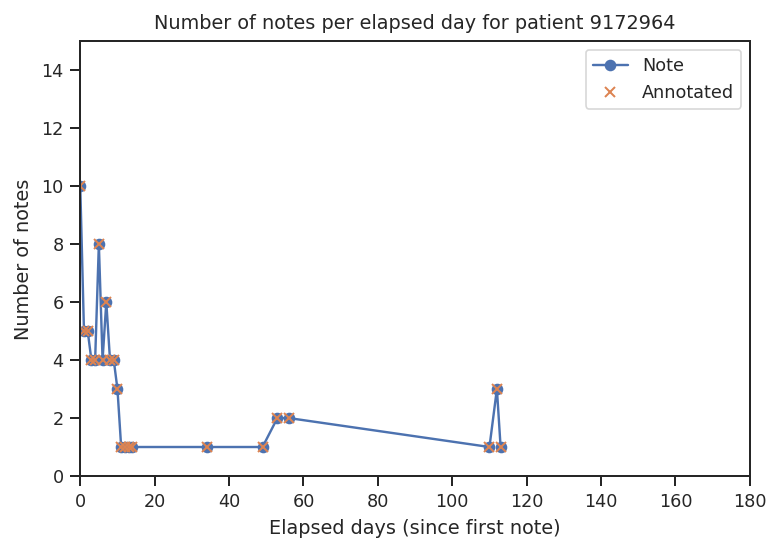

772676


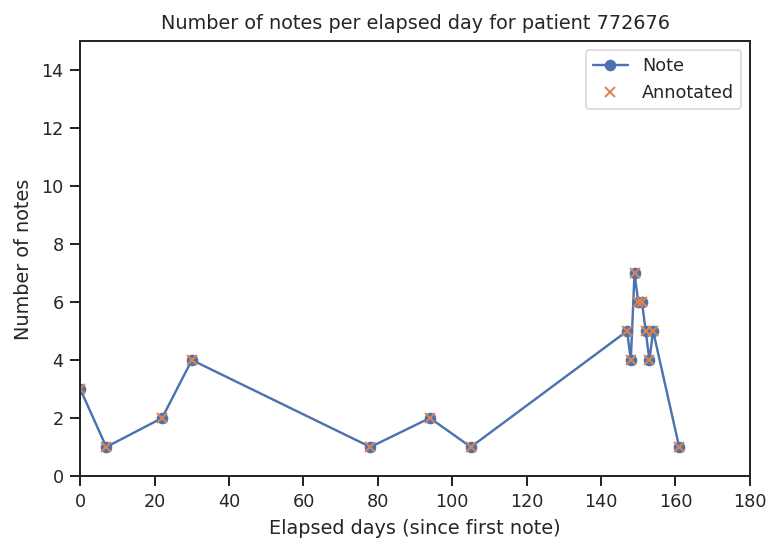

6403079


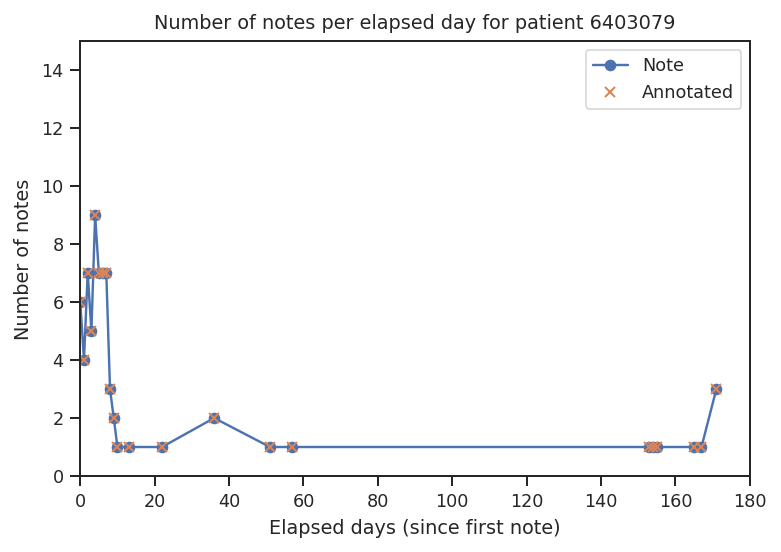

8555667


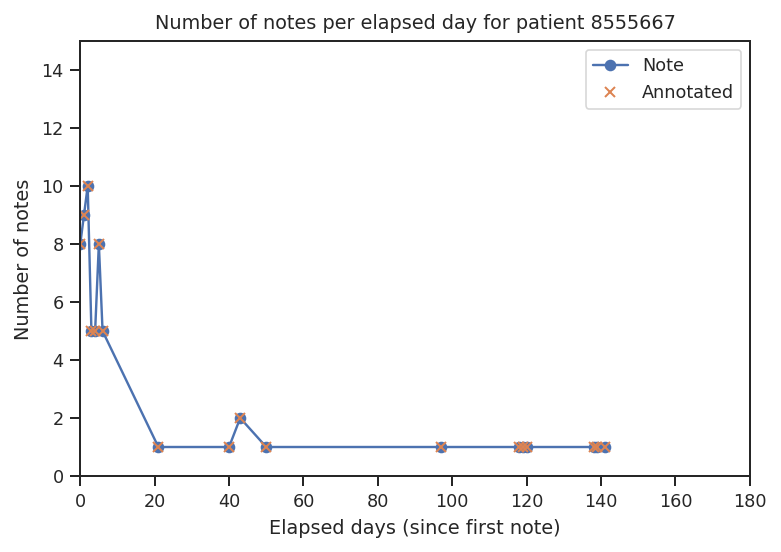

3174190


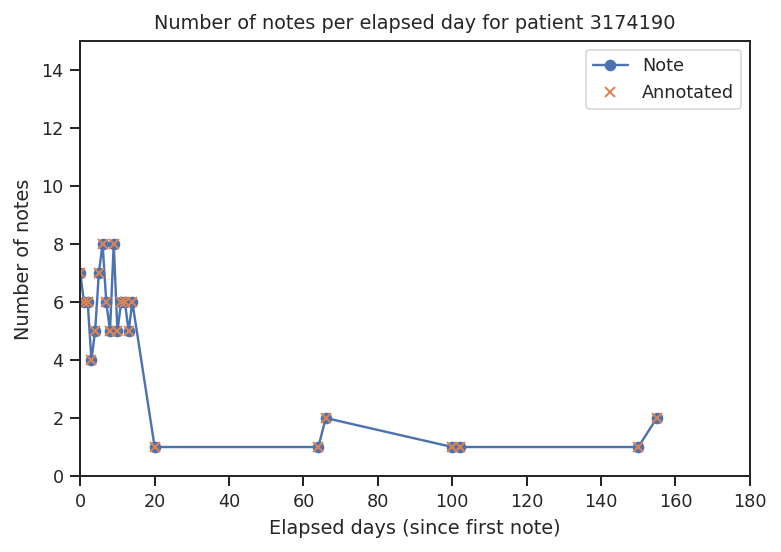

1825193


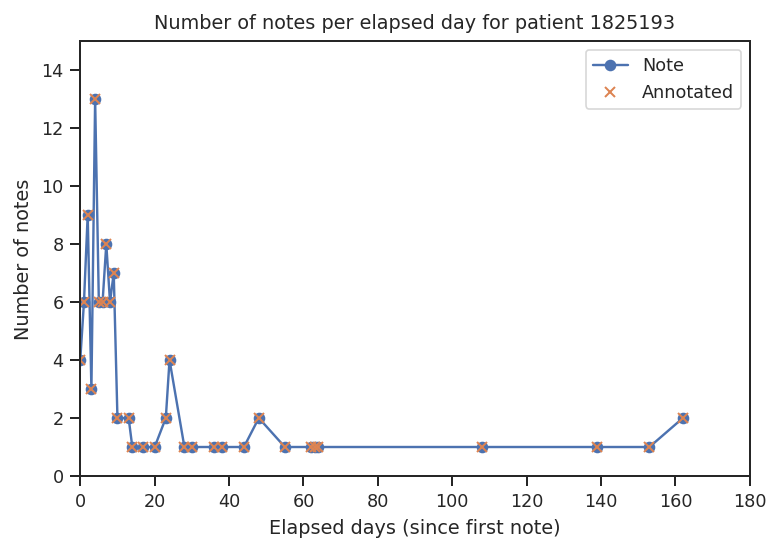

1516667


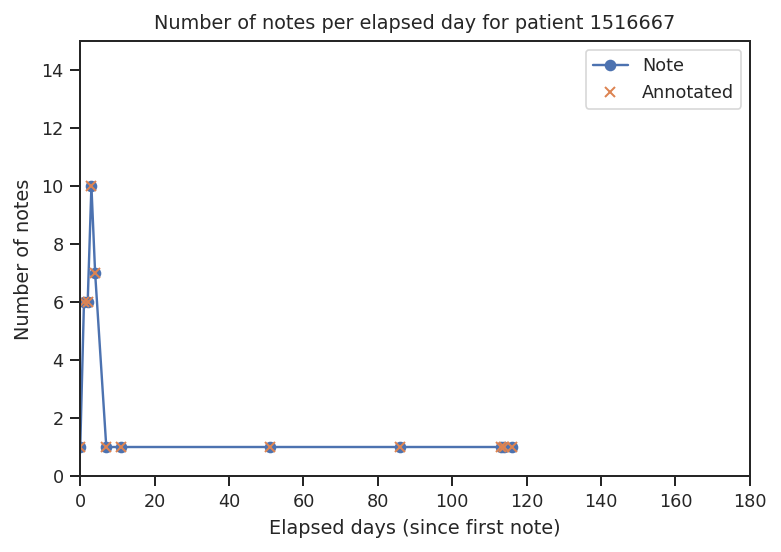

1827868


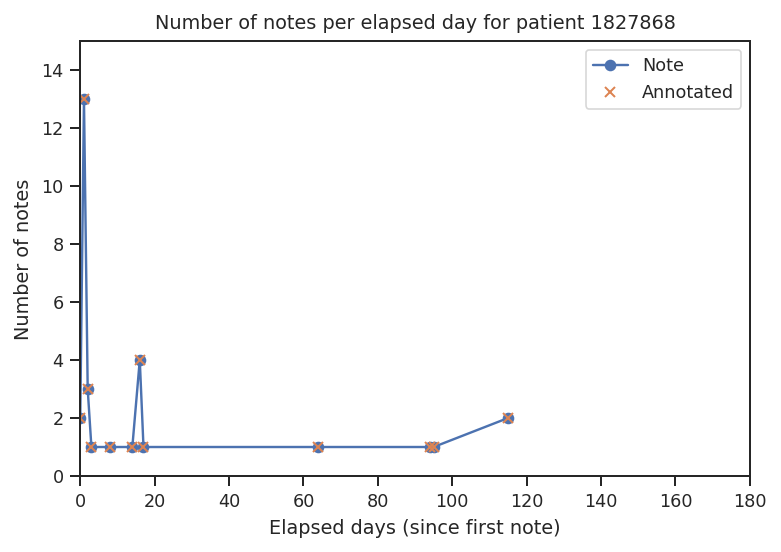

8012257


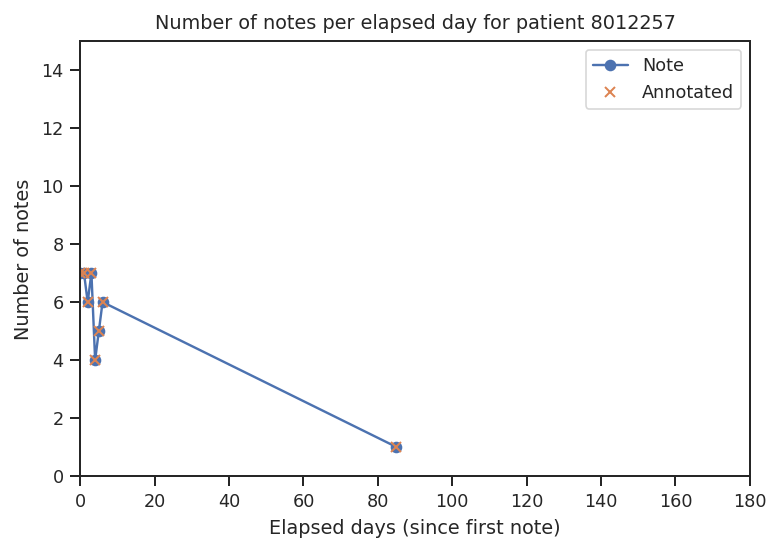

1826470


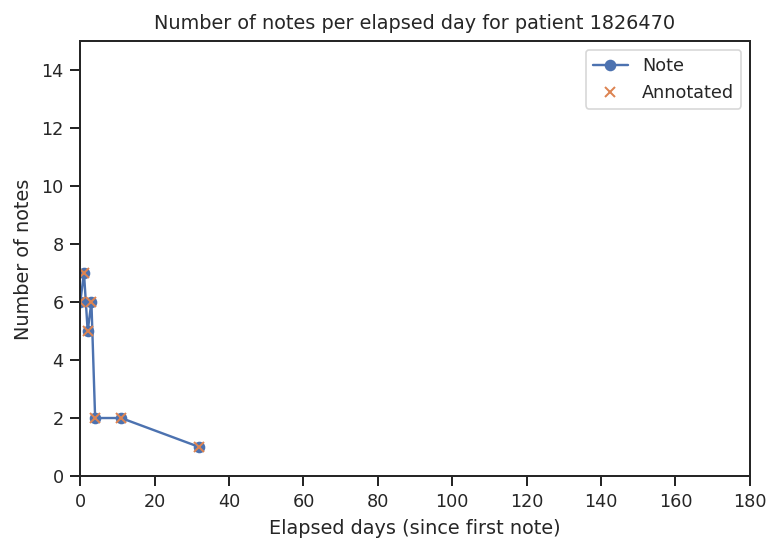

1701305


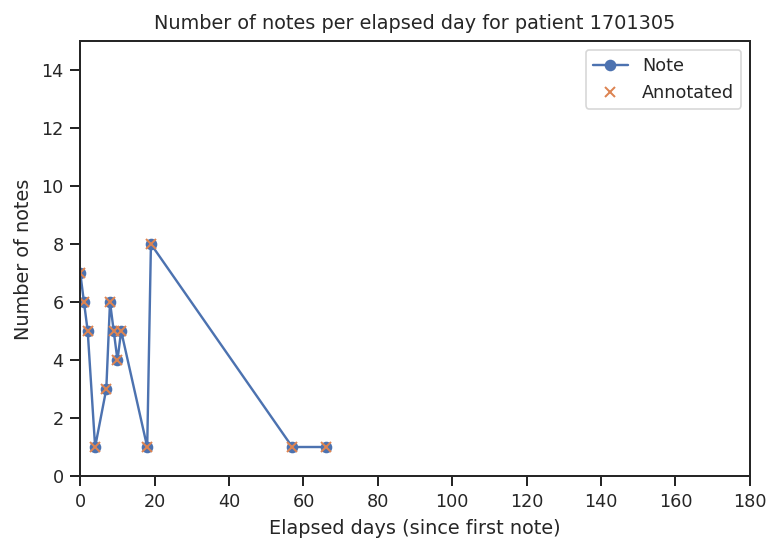

1733802


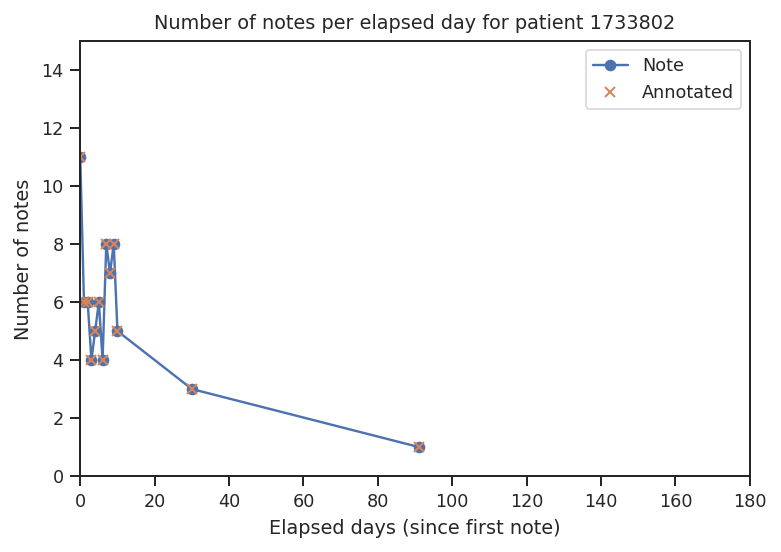

1830568


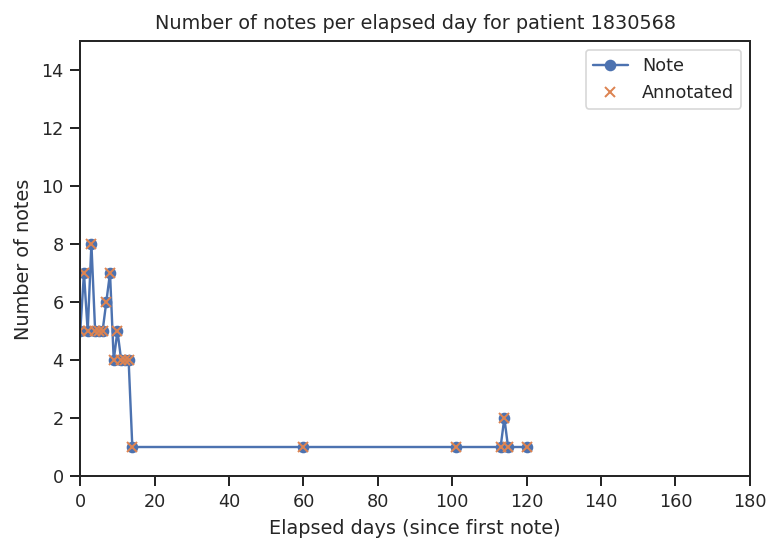

1828353


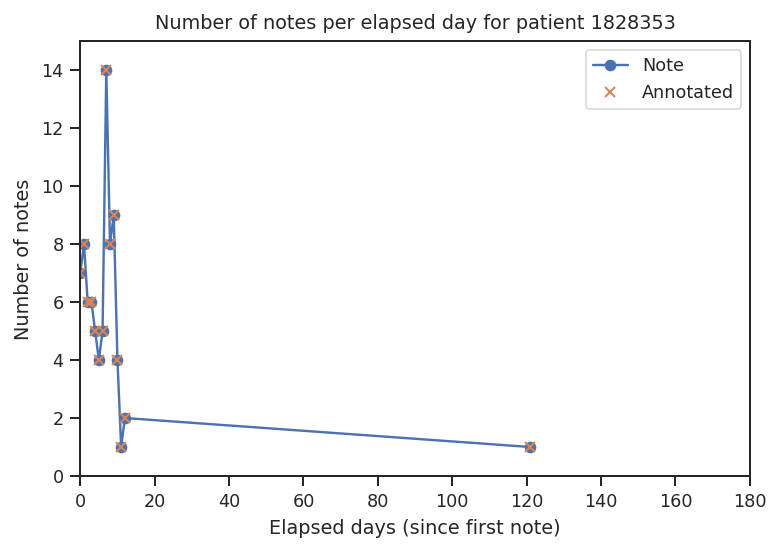

6779382


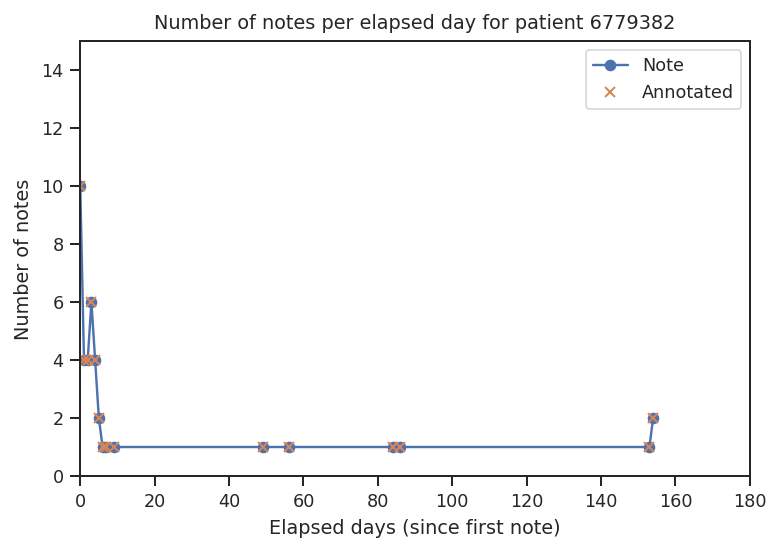

1829083


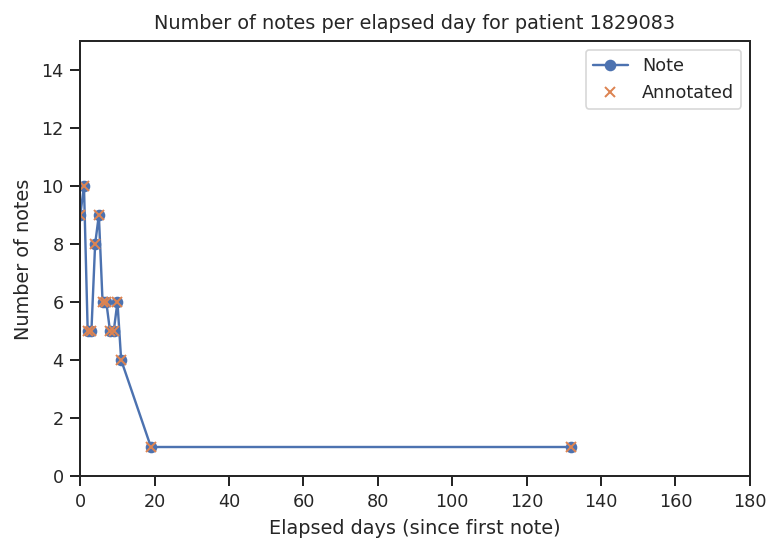

1833136


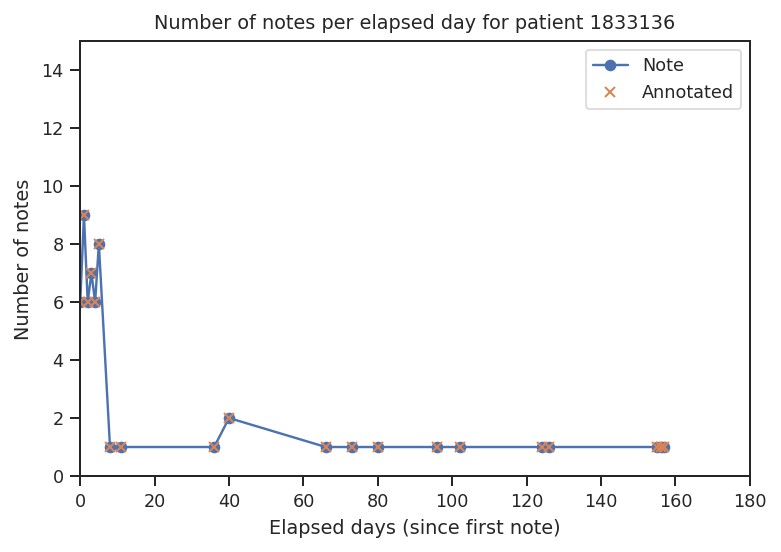

1683660


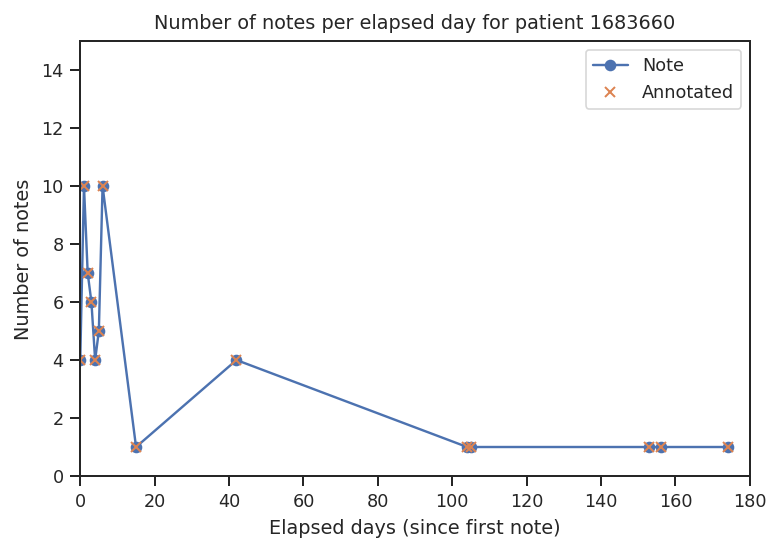

2727819


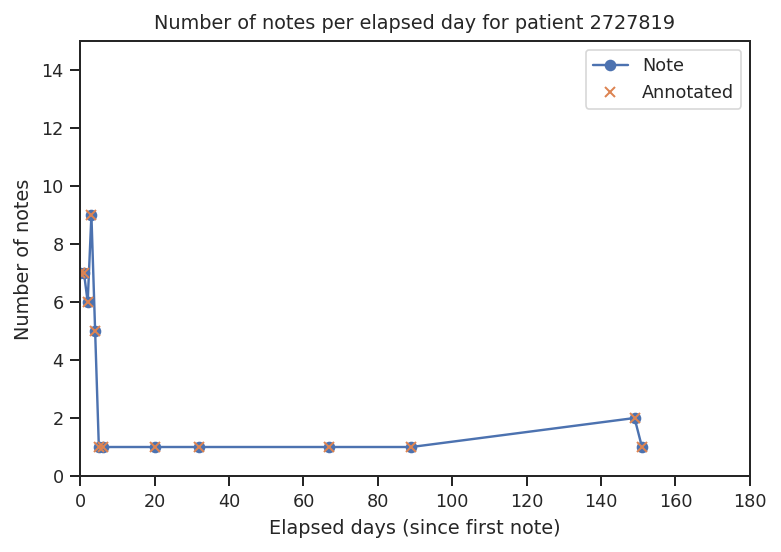

7002288


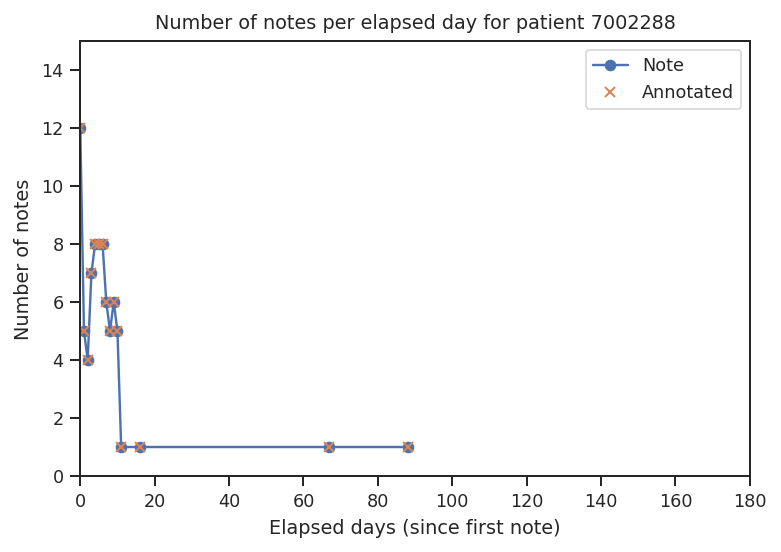

9058241


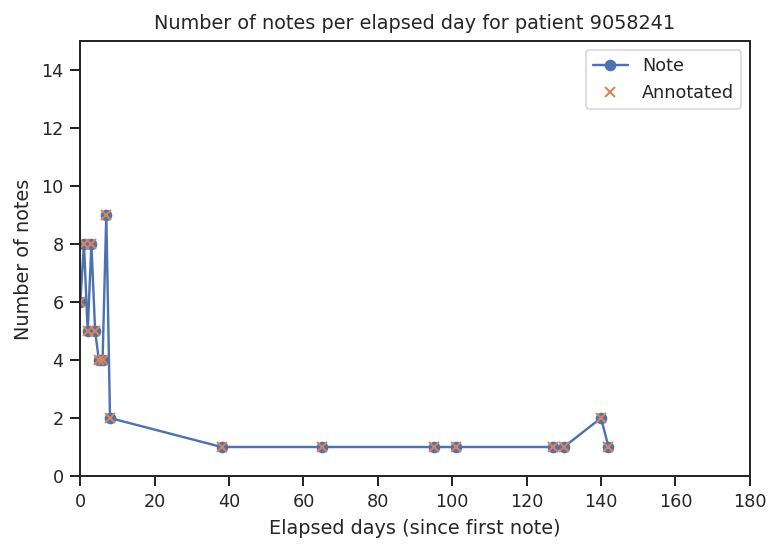

1826708


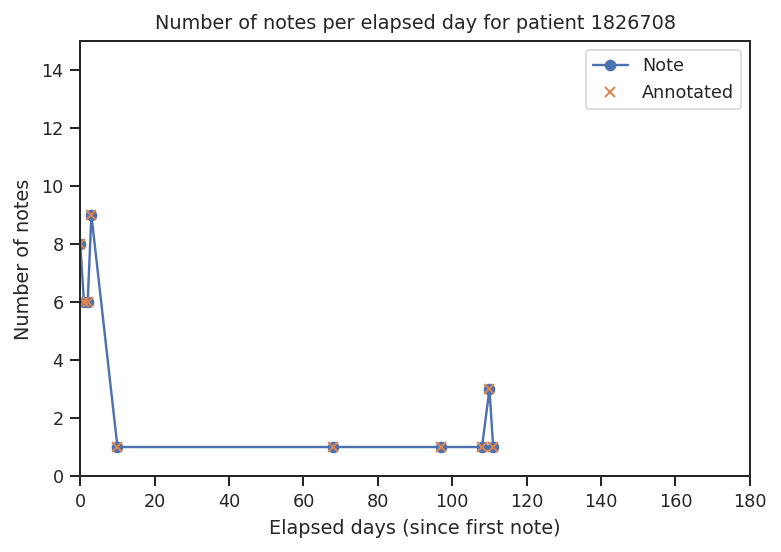

1830231


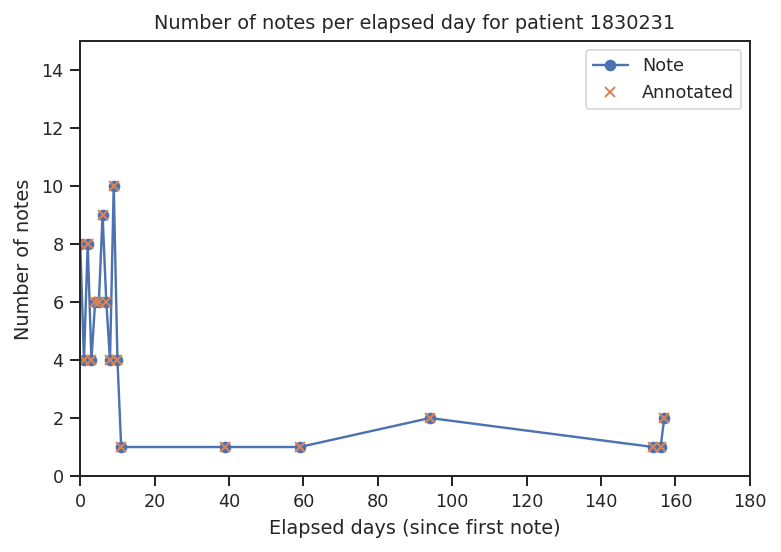

8581219


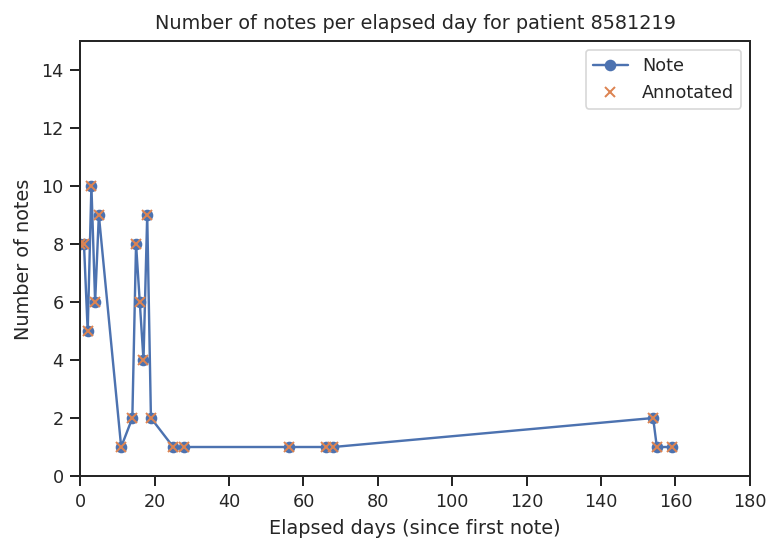

1245032


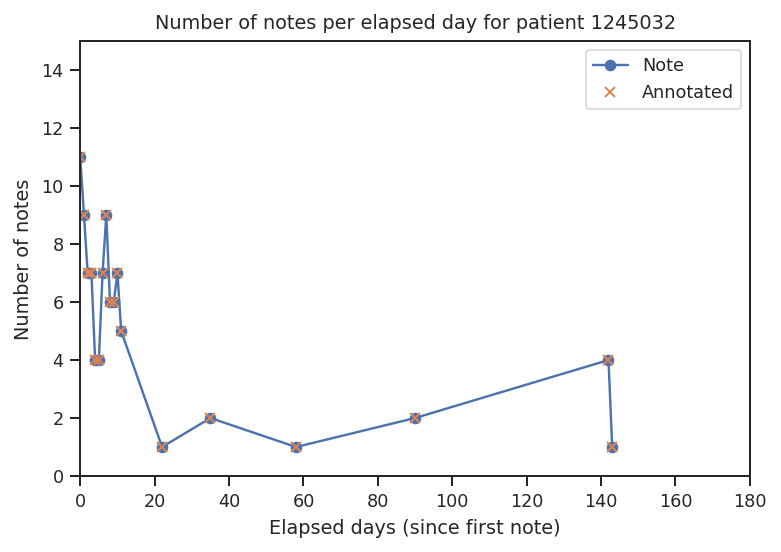

7256295


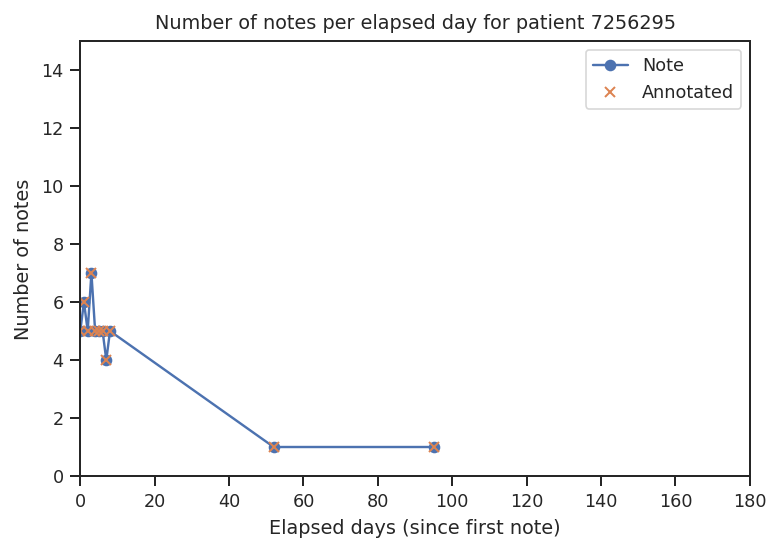

8297685


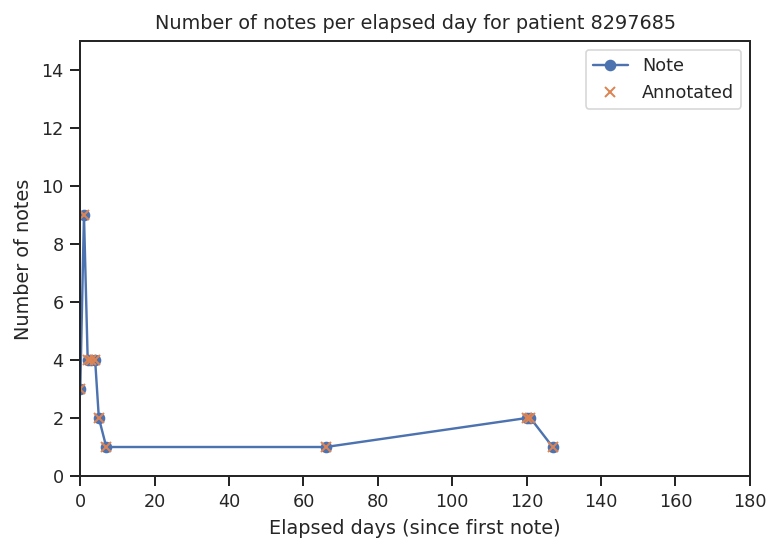

3949143


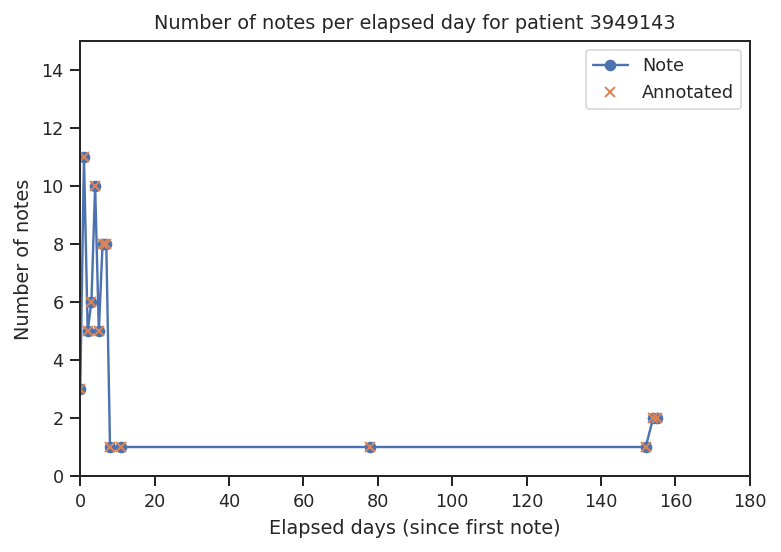

1228841


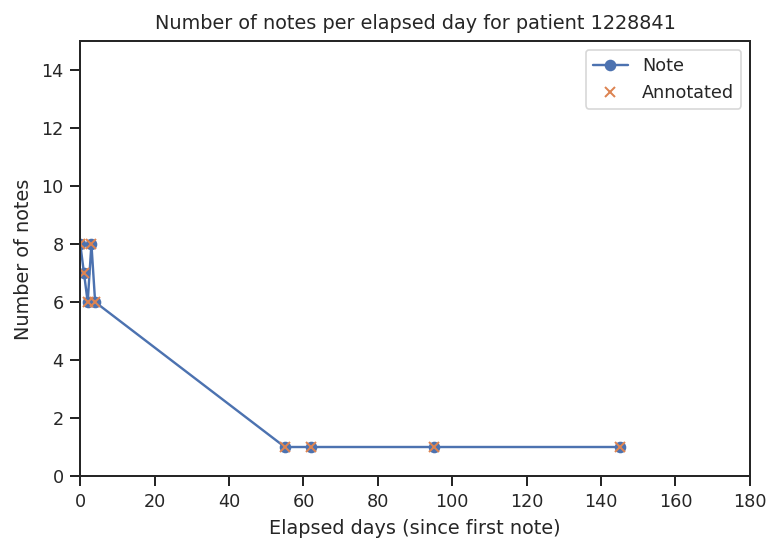

1776065


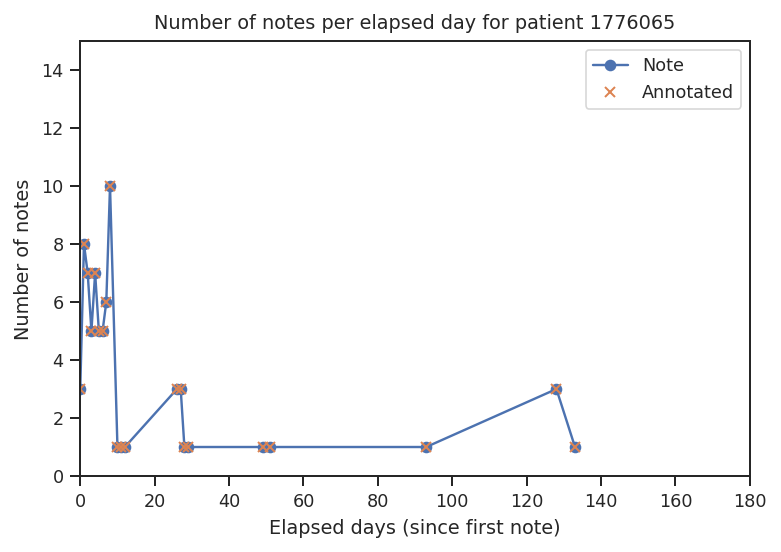

1836190


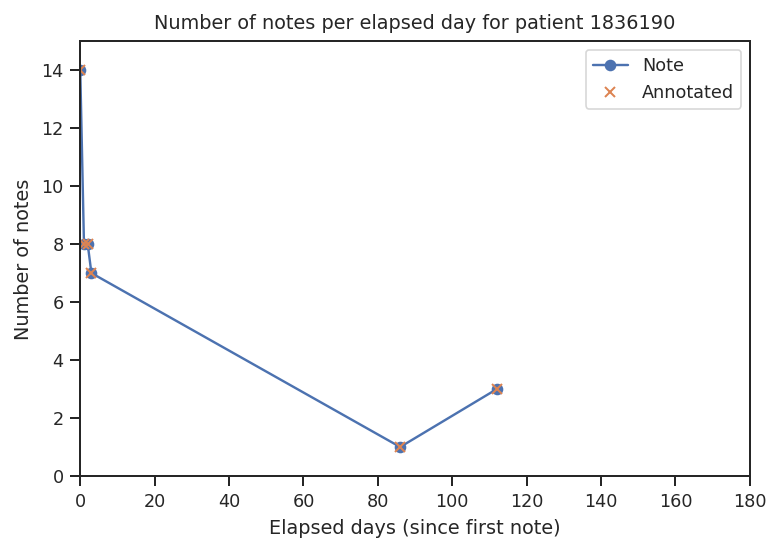

6308072


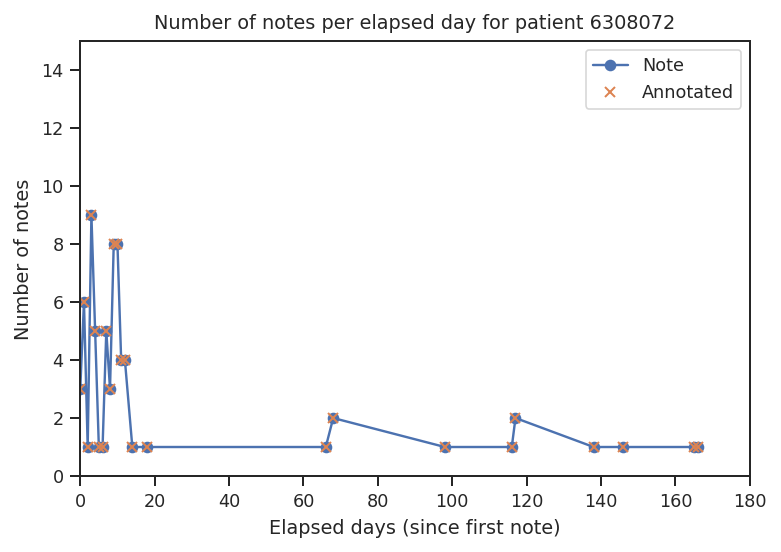

1828584


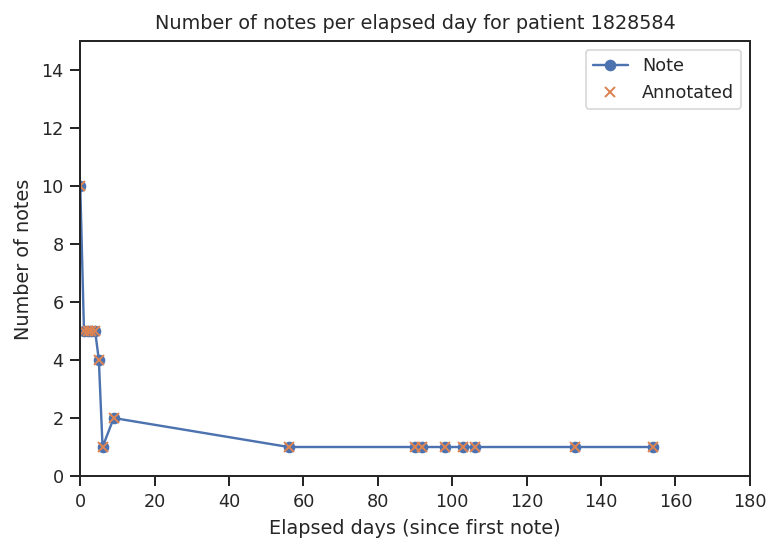

7283210


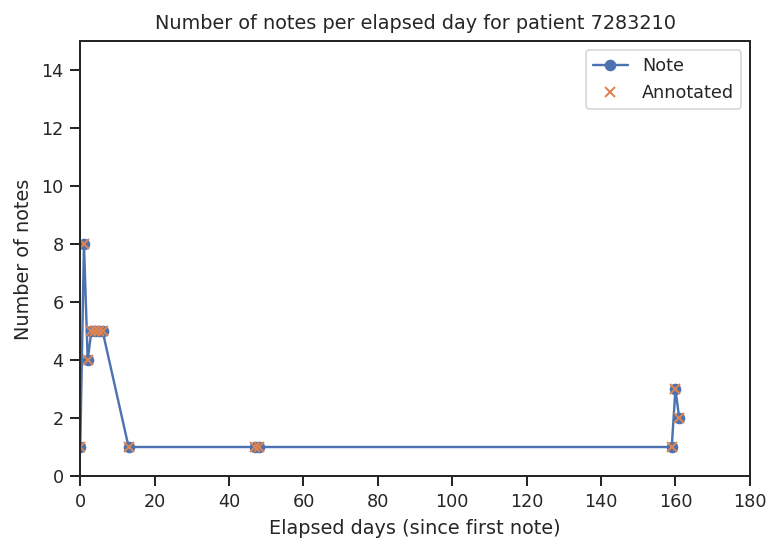

3007670


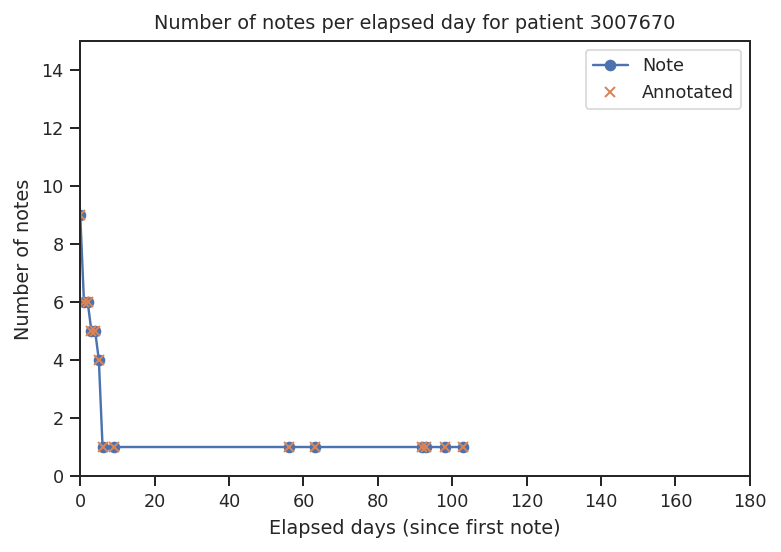

In [12]:
# Detecting different periods in patient history

for pid in df.patient_id.unique():
    print(pid)
    _df = df[df.patient_id == pid]
    _df = _df.groupby('elapsed_days').count()
    _df['note_id'].plot(marker='o', label='Note')
    _df.dropna(subset=DOMAINCOLS, how='all')['note_id'].plot(marker='x', linestyle='None', label='Annotated')

    plt.ylabel('Number of notes')
    plt.xlabel('Elapsed days (since first note)')
    plt.title(f'Number of notes per elapsed day for patient {pid}')
    plt.xlim(0,180)
    plt.ylim(0, 15)
    plt.legend()
    plt.show()

In [13]:
# Manually exclude some patients whose progression isn't conducive to our analysis

bad_patients = [str(x) for x in [
    772676,
    1827868,
    8012257,
    1826470,
    1701305,
    1733802,
    1683660,
    7002288,
    7256295,
    1836190,
]]

df = df[~df.patient_id.isin(bad_patients)]
df.patient_id.nunique()

28

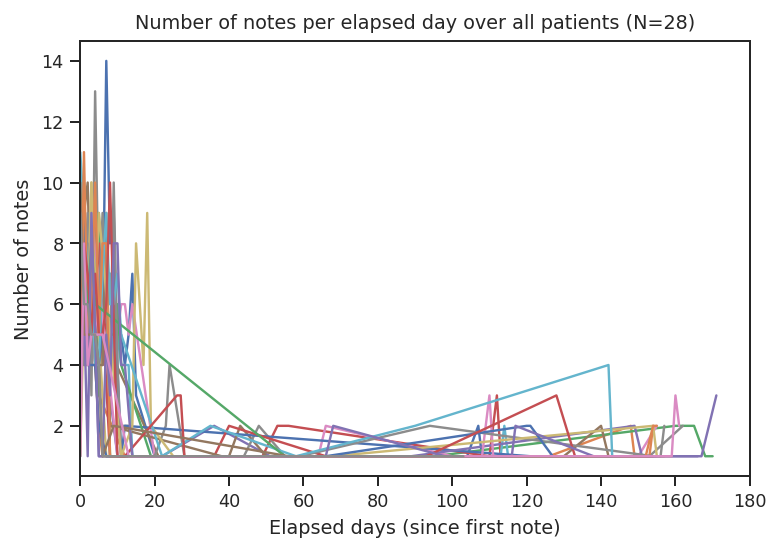

In [14]:
# Detecting different periods in patient history

for pid in df.patient_id.unique():
    _df = df[df.patient_id == pid]
    _df = _df.groupby('elapsed_days').count()
    _df['note_id'].plot()

plt.ylabel('Number of notes')
plt.xlabel('Elapsed days (since first note)')
plt.title(f'Number of notes per elapsed day over all patients (N={df.patient_id.nunique()})')
plt.xlim(0,180)
plt.show()

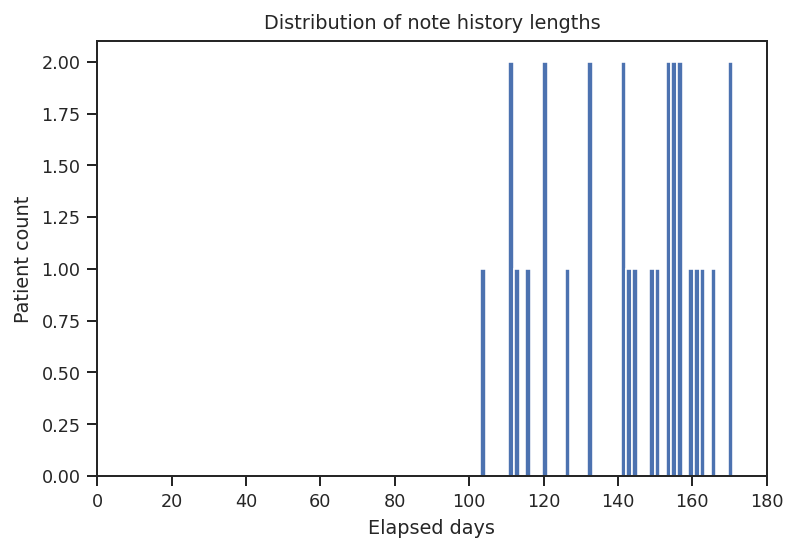

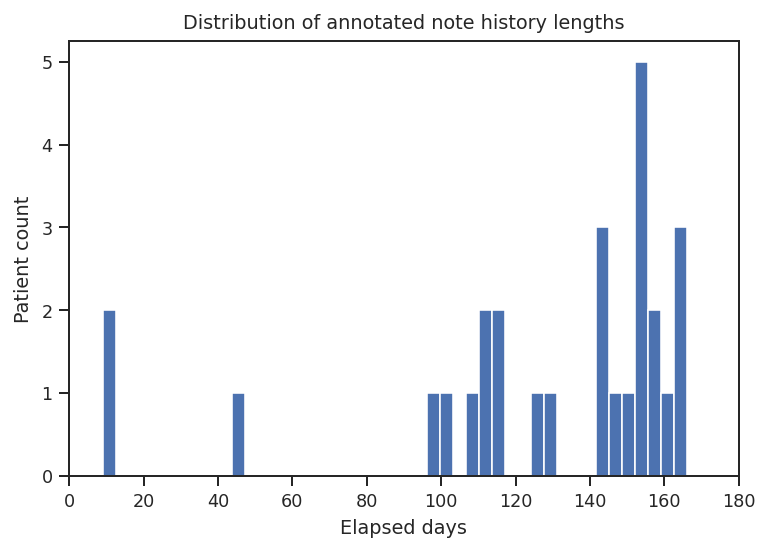

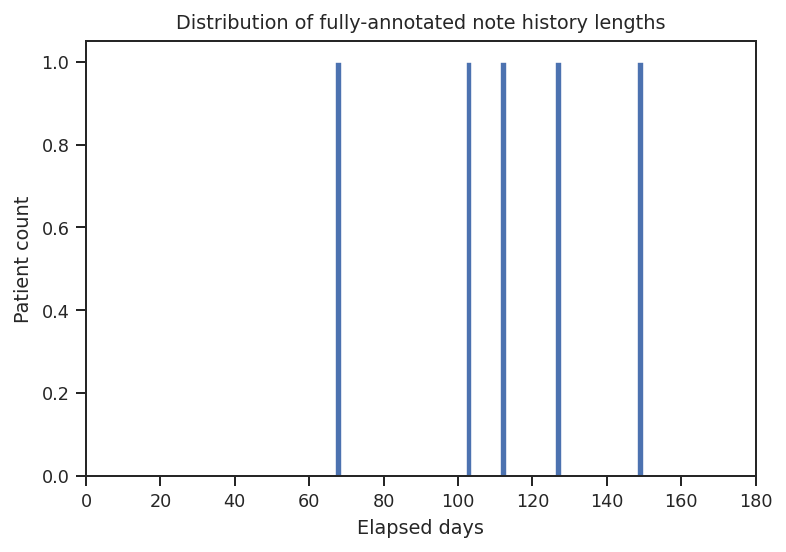

In [15]:
max_days = [df[df.patient_id == pid].elapsed_days.max() for pid in df.patient_id.unique()]
plt.hist(max_days, bins=45)
plt.title('Distribution of note history lengths')
plt.xlabel('Elapsed days')
plt.ylabel('Patient count')
plt.xlim(0, 180)
plt.show()

max_annot_days = [df[df.patient_id == pid].dropna(how='all', subset=DOMAINCOLS).elapsed_days.max() for pid in df.patient_id.unique()]
plt.hist(max_annot_days, bins=45)
plt.title('Distribution of annotated note history lengths')
plt.xlabel('Elapsed days')
plt.ylabel('Patient count')
plt.xlim(0, 180)
plt.show()


max_annot_days = [df[df.patient_id == pid].dropna(how='any', subset=DOMAINCOLS).elapsed_days.max() for pid in df.patient_id.unique()]
plt.hist(max_annot_days, bins=45)
plt.title('Distribution of fully-annotated note history lengths')
plt.xlabel('Elapsed days')
plt.ylabel('Patient count')
plt.xlim(0, 180)
plt.show()

## Ad 1.1.1: What is the mean or median level of functioning on the different ICF domains at hospital admission, at hospital discharge and at the 6 weeks and 3 months outpatient visits? 

       STM_level  INS_level  BER_level  FAC_level
count     24.000     26.000        1.0     28.000
mean       1.479      1.538        4.0      3.339
std        0.827      0.859        NaN      1.218
min        0.000      0.500        4.0      0.000
25%        1.000      1.000        4.0      3.000
50%        1.000      1.250        4.0      4.000
75%        2.000      2.000        4.0      4.000
max        3.000      5.000        4.0      5.000


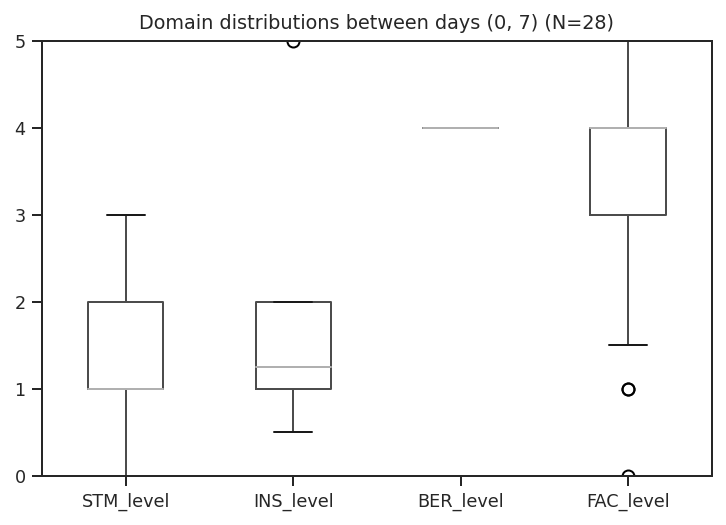

       STM_level  INS_level  BER_level  FAC_level
count     14.000     13.000        0.0     16.000
mean       2.321      1.885        NaN      3.062
std        0.912      0.768        NaN      1.526
min        1.000      1.000        NaN      0.000
25%        2.000      1.000        NaN      2.000
50%        2.250      2.000        NaN      4.000
75%        3.000      2.000        NaN      4.000
max        4.000      3.500        NaN      4.000


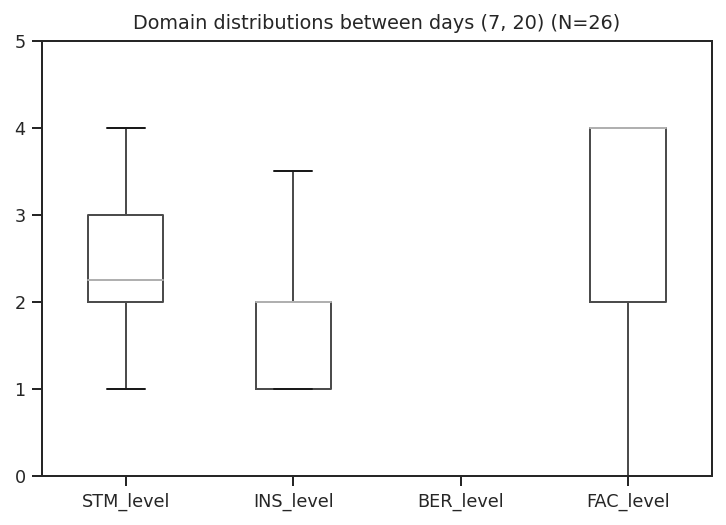

       STM_level  INS_level  BER_level  FAC_level
count     15.000     23.000      5.000     15.000
mean       2.067      3.217      2.200      4.800
std        0.799      1.126      0.837      0.414
min        1.000      1.000      1.000      4.000
25%        2.000      2.500      2.000      5.000
50%        2.000      3.000      2.000      5.000
75%        2.000      4.000      3.000      5.000
max        4.000      5.000      3.000      5.000


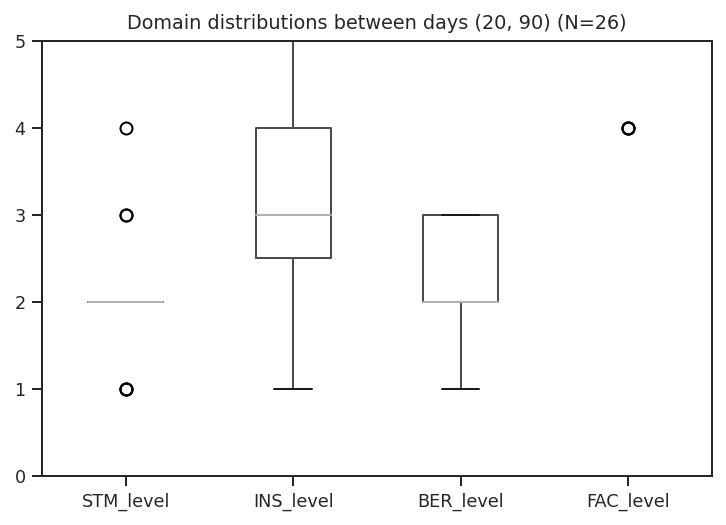

       STM_level  INS_level  BER_level  FAC_level
count     12.000     24.000      9.000     16.000
mean       2.500      3.375      2.889      4.750
std        1.148      0.981      0.928      0.447
min        0.500      2.000      2.000      4.000
25%        2.000      3.000      2.000      4.750
50%        2.250      3.000      3.000      5.000
75%        3.250      4.000      4.000      5.000
max        4.000      5.000      4.000      5.000


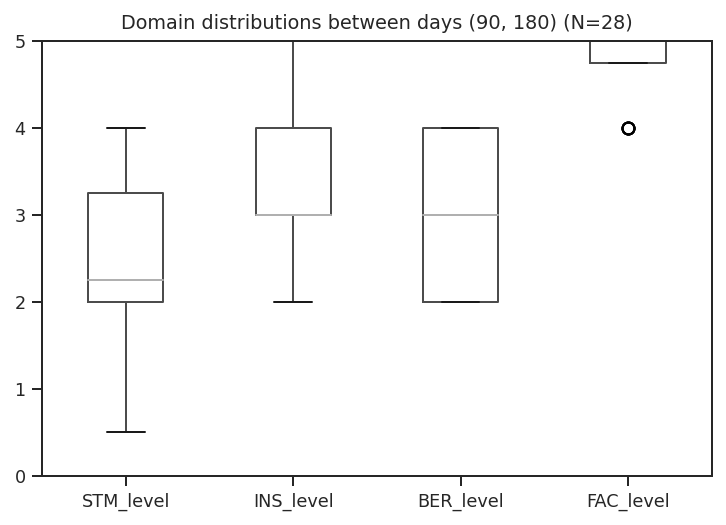

In [16]:
for day_range in [(0, 7), (7,20), (20, 90), (90, 180)]:
    _df = df[df.elapsed_days.between(*day_range)].groupby('patient_id').median()
    print(_df[DOMAINCOLS].describe().round(3))
    _df[DOMAINCOLS].boxplot(grid=False)
    plt.title(f"Domain distributions between days {day_range} (N={_df.shape[0]})")
    plt.ylim(0,5)
    plt.show()

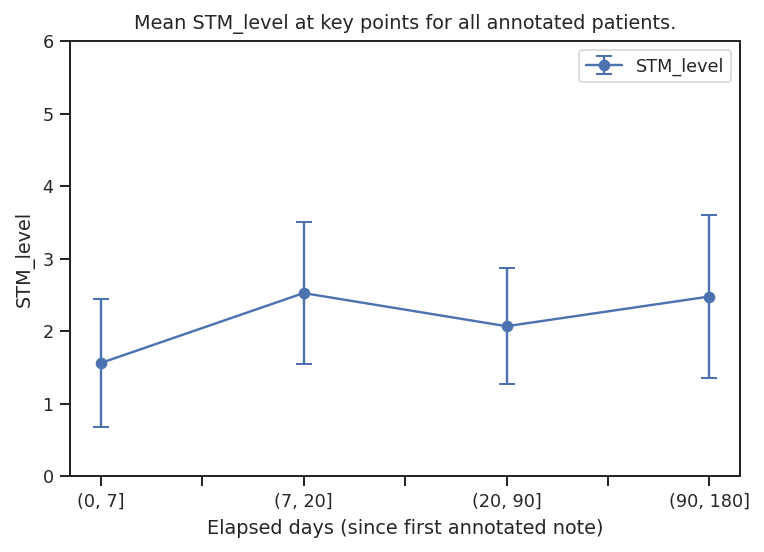

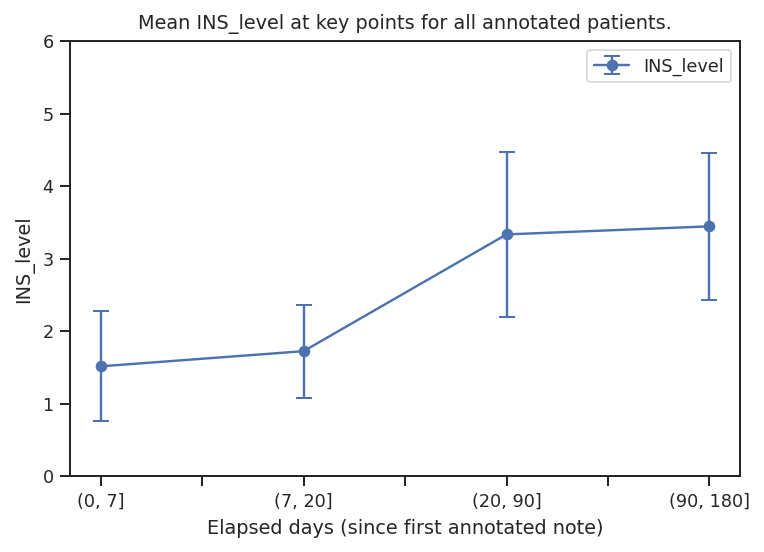

/data/homedirs/gianluca/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/data/homedirs/gianluca/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


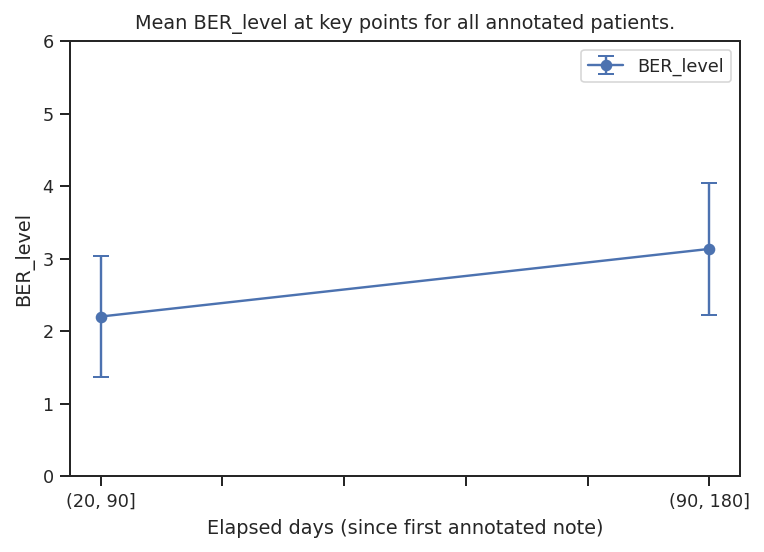

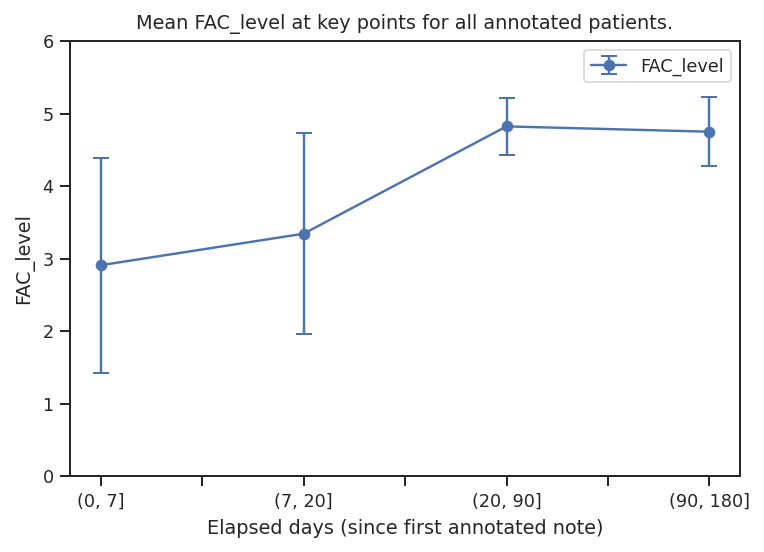

In [17]:
_df = df.groupby(['elapsed_days', 'patient_id']).median()[DOMAINCOLS].reset_index()
_df = _df.groupby(pd.cut(
        _df.elapsed_days, [0, 7, 20, 90, 180])
                 ).agg({c: ['mean', 'std'] for c in DOMAINCOLS})
for c in DOMAINCOLS:
    _df[(c, 'mean')].plot(
        marker='o', yerr=_df[(c, 'std')], 
        capsize=4, label=c,
        ylim=(0,6),
    )    
    plt.legend()
    plt.title(f'Mean {c} at key points for all annotated patients.')
    plt.ylabel(c)
    plt.xlabel('Elapsed days (since first annotated note)')
    plt.show()

## Ad 1.1.2: What is the mean course in the level of functioning of these domains during hospital stay (from admission to discharge)? 

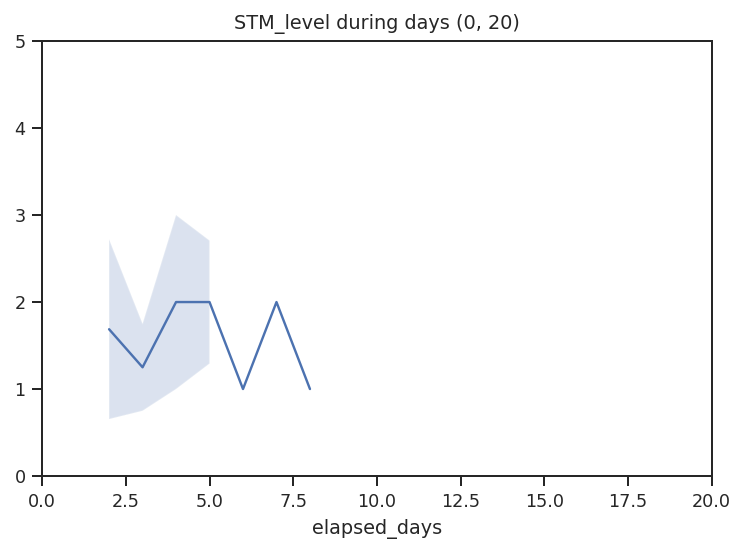

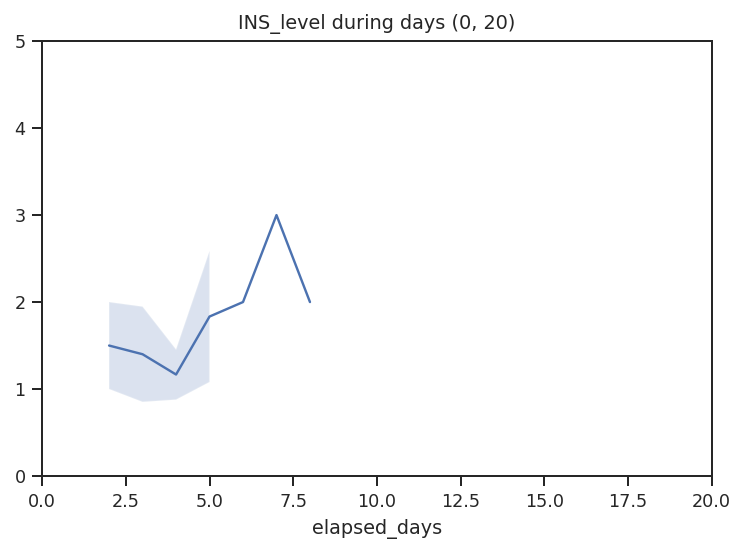

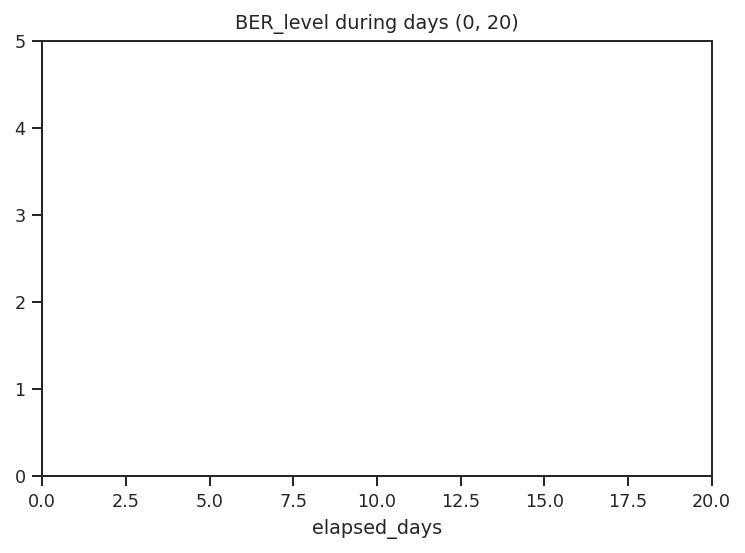

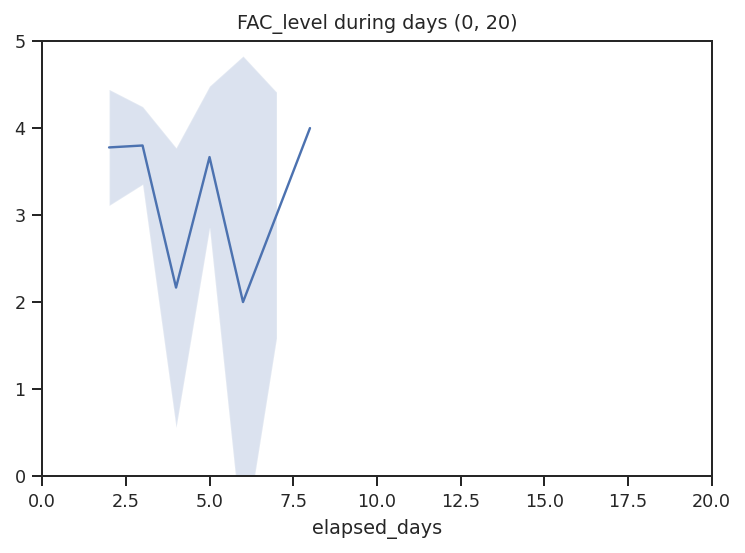

In [18]:
date_range = (0, 20)
_df = df[df.elapsed_days.between(*date_range)].groupby('patient_id').median()
_df = _df.groupby('elapsed_days').agg({c: ['mean', 'std'] for c in DOMAINCOLS})

for c in DOMAINCOLS:
    fig, ax = plt.subplots(1,1)
    _df[(c, 'mean')].plot(ax=ax, label=c)
    means, stds = _df[(c, 'mean')].values, _df[(c, 'std')].values
    plt.fill_between(_df.reset_index().elapsed_days, means - stds, means + stds, alpha=0.2)
    plt.xlim(date_range)
    plt.ylim(0, 5)
#     plt.legend()
    plt.title(f"{c} during days {date_range}")
    plt.show()

## Ad 1.1.3: What is the frequency per ICF domain/level? 

In [19]:
df[DOMAINCOLS].describe()

,STM_level,INS_level,BER_level,FAC_level
count,188.000000,269.000000,22.000000,288.000000
mean,1.765957,2.070632,2.909091,3.222222
std,1.048814,1.230305,0.971454,1.588041
min,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,2.000000,2.000000
50%,2.000000,2.000000,3.000000,4.000000
75%,3.000000,3.000000,4.000000,4.000000
max,4.000000,5.000000,4.000000,5.000000


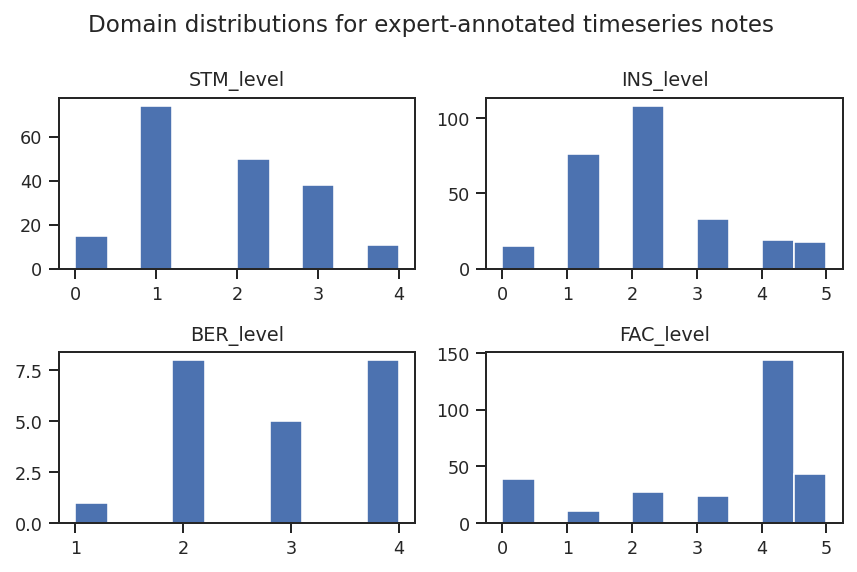

In [20]:
df[DOMAINCOLS].hist(grid=False)
plt.suptitle("Domain distributions for expert-annotated timeseries notes")
plt.tight_layout()
plt.show()

In [21]:
df.groupby(['elapsed_days', 'patient_id']).median()[DOMAINCOLS].describe()

,STM_level,INS_level,BER_level,FAC_level
count,123.00000,189.000000,21.000000,186.000000
mean,1.95122,2.275132,2.952381,3.475806
std,1.01508,1.262582,0.973457,1.466087
min,0.00000,0.000000,1.000000,0.000000
25%,1.00000,1.000000,2.000000,3.000000
50%,2.00000,2.000000,3.000000,4.000000
75%,3.00000,3.000000,4.000000,4.000000
max,4.00000,5.000000,4.000000,5.000000


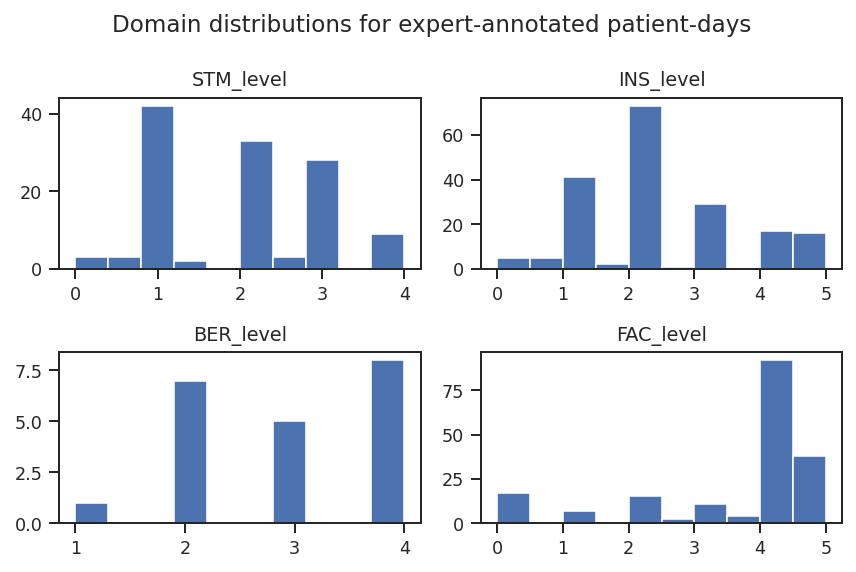

In [22]:
df.groupby(['elapsed_days', 'patient_id']).median()[DOMAINCOLS].hist(grid=False)
plt.suptitle("Domain distributions for expert-annotated patient-days")
plt.tight_layout()
plt.show()

## Ad 1.1.4: How many patients improve from discharge to follow-up, how many remain the same? How many deteriorate?

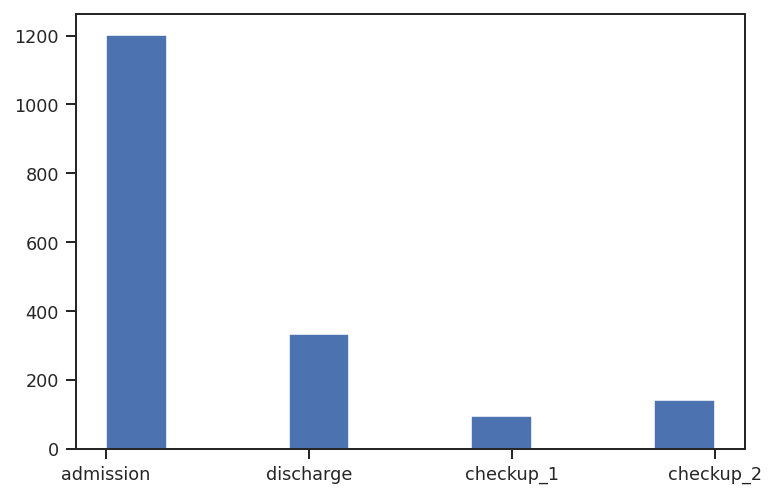

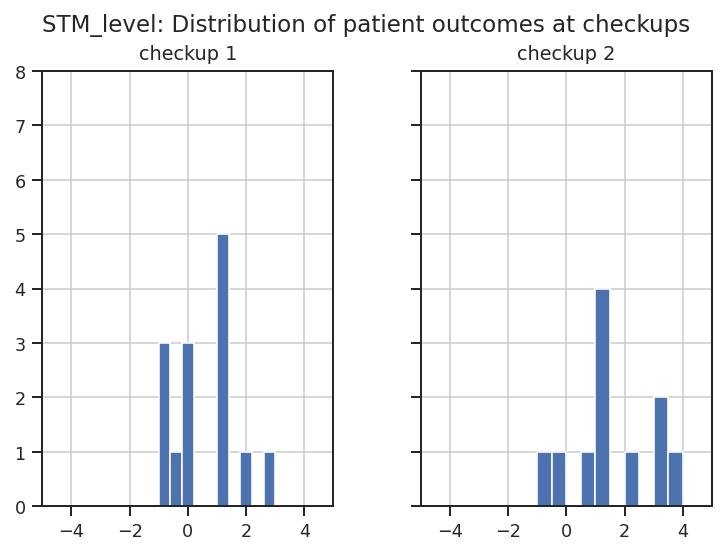

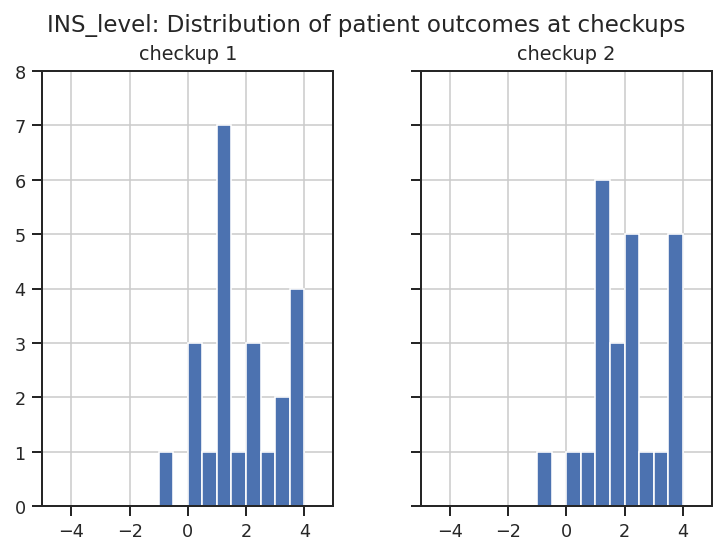

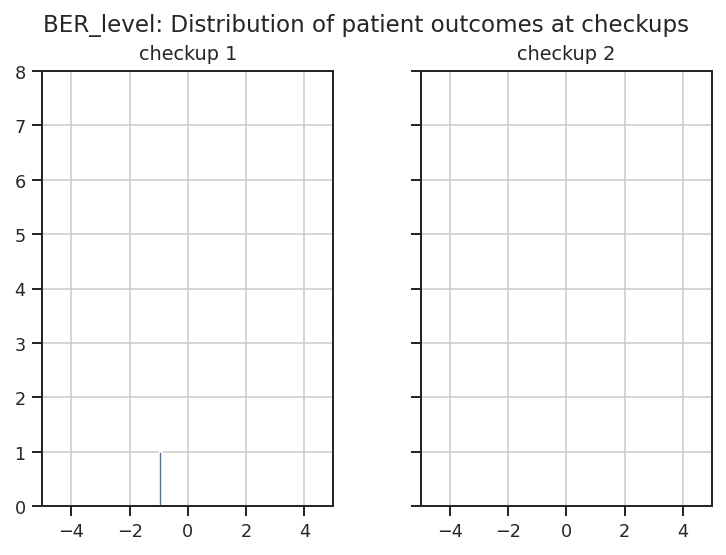

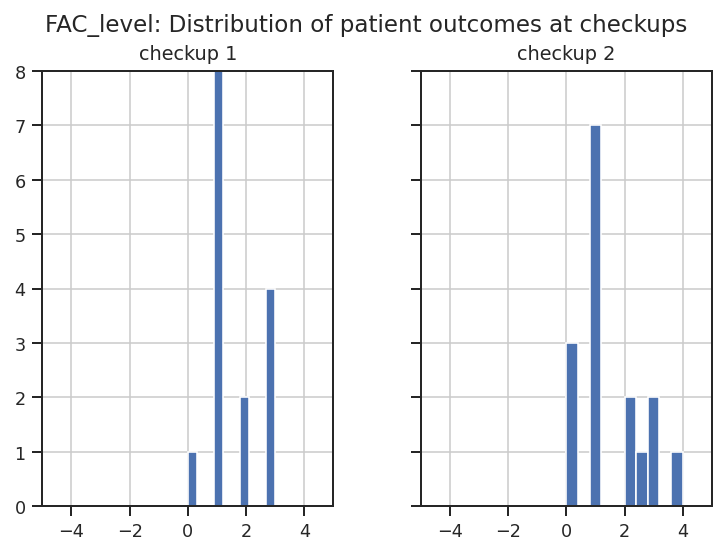

In [23]:
def elapsed_to_period(day):
    if day <= 7:
        return 'admission'
    elif 7 < day <= 20:
        return 'discharge'
    elif 20 < day <= 90:
        return 'checkup_1'
    elif 90 < day <= 180:
        return 'checkup_2'
    else:
        return np.nan
    
_df = df.copy()
_df['period'] = _df.elapsed_days.apply(elapsed_to_period)
_df.period.hist(grid=False)
plt.show()


from collections import defaultdict

domain_deltas = defaultdict(list)

# We don't have enough data for discharge, so we have to use admission
_df = _df.groupby(['patient_id', 'period']).median()[DOMAINCOLS].reset_index()
for c in DOMAINCOLS:
    periods = pd.pivot_table(_df, values=c, index=['patient_id'], columns=['period'])
    periods['checkup 1'] = periods.checkup_1 - periods.admission
    periods['checkup 2'] = periods.checkup_2 - periods.admission
    periods[['checkup 1', 'checkup 2']].hist(sharey=True, sharex=True)
    plt.xlim(-5,5)
    plt.ylim(0,8)
    plt.suptitle(f'{c}: Distribution of patient outcomes at checkups')
    plt.show()